# AdventureWorks Försäljningsanalys
I denna analys undersöker vi AdventureWorks- databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Zemer6969")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\kaisa\AppData\Local\Temp\ipykernel_6704\2621769548.py:23: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

Tabeller som används:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

Plan:
1. JOINa tabellerna 
2. Räkna DISTINCT produkt per kategori
3. Skapa verikalt stapeldiagram
4. Analysera resultatet

In [13]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT (DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
LEFT JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

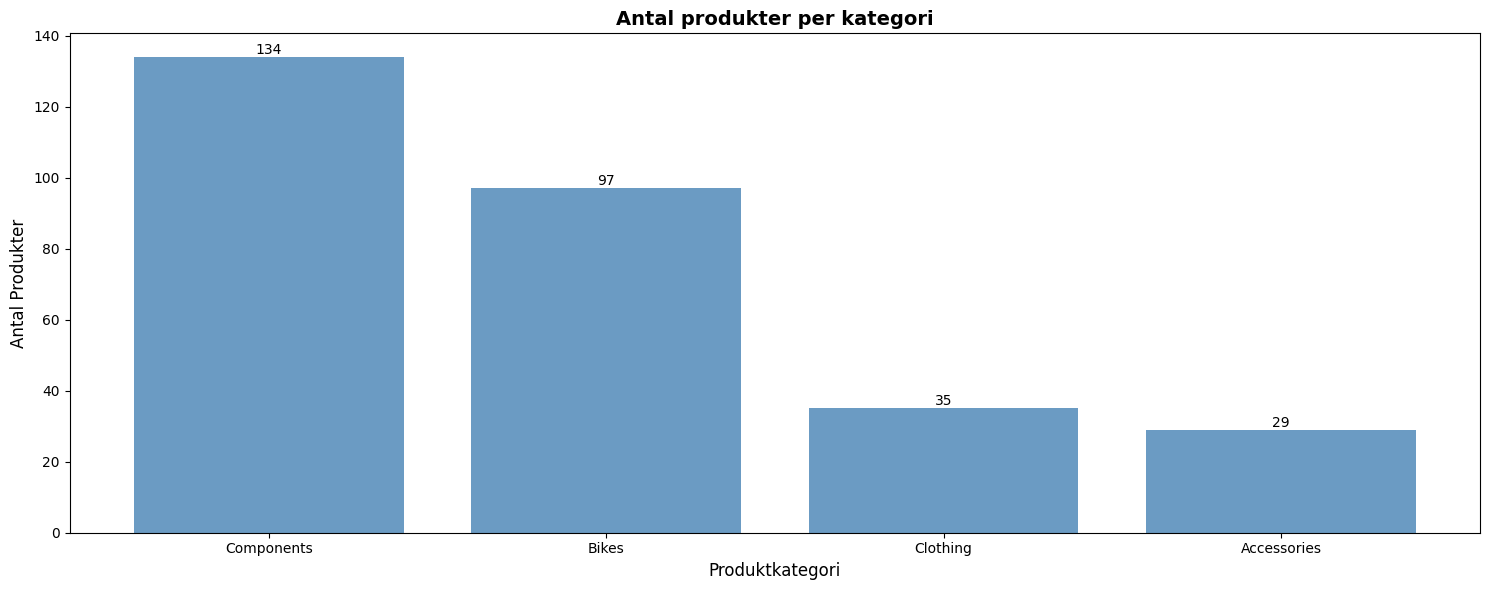

In [25]:
fig, ax = plt.subplots(figsize = (15, 6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color= 'steelblue', alpha= 0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
    bar.get_x() + bar.get_width()/2,
    height,
    f'{int(height)}',
    ha = 'center',
    va = 'bottom'
    )

ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Antal Produkter', fontsize = 12)
ax.set_title('Antal produkter per kategori', fontsize= 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

### Insikter - antal produkter per kategori
Components är största kategorin med 134 produkter.
Accessories är minst med 29 produkter.

Detta indikerar på att företaget är stark fokuserad på komponenter och reservdelar. Och att accessories kan vara ett utvecklingsområde.

## Visualisering 2: Försäljning per produktkategori
Vilka produktkategorier genererar mest intäkter?

Tabeller som används:
- Production.ProductCategory,
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

Plan:
1. JOINa tabellerna 
2. Få fram vilken kategori som är störst och minst, med exakta siffror
3. Skapa horisontellt stapeldiagram (barh)
4. Analysera resultatet

In [21]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    CAST(SUM (sod.LineTotal) AS decimal(18,2)) AS TotalOmsättning
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID

GROUP BY pc.Name
ORDER BY TotalOmsättning DESC;
"""

df_vis2 = query_df(query_vis2)

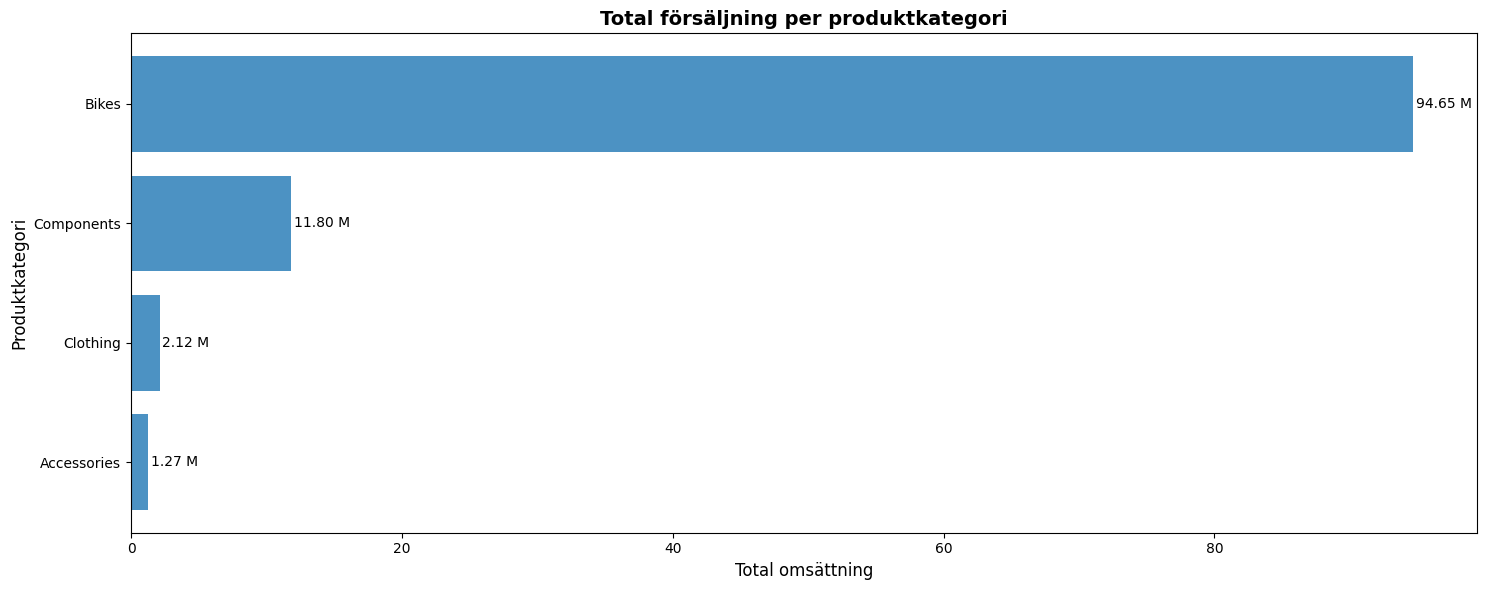

In [24]:
df_vis2 = df_vis2.sort_values('TotalOmsättning', ascending = False)
df_vis2 = df_vis2.iloc[::-1]                                            # störst överst

fig, ax = plt.subplots(figsize = (15, 6))

bars = ax.barh(
    df_vis2['CategoryName'],
    df_vis2['TotalOmsättning']/ 1_000_000,                               # i miljoner
    alpha = 0.8
)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 0.2,
        bar.get_y() + bar.get_height()/ 2,
        f'{width:.2f} M',
        va = 'center'
    )

ax.set_xlabel('Total omsättning', fontsize = 12)
ax.set_ylabel('Produktkategori', fontsize = 12)
ax.set_title('Total försäljning per produktkategori', fontsize= 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

### Insikter - Försäljning per produktkategori

Kategorin Bikes är den som genererar högst omsättning med ~ 94,7 miljoner, följt av Components ~ 11,8 miljoner.

Omsättningen är beräknad med hjälp av LineTotal, vilket inkluderar eventuella rabatter och därför ger en mer korrekt och rymlig bild av faktisk försäljning 

Kategori Accessories säljer minst med omsättning på ungefär 1,27 miljoner (största utvecklingsområde).


## Visualisering 2: Försäljning över tid
Hur har försäljningen utvecklats över tid?

Tabeller som används:
- Sales.SalesOrderHeader

Plan:
1. Aggregera per månad (minst 12 månader data) 
2. Få fram trenden - ökar försäljning, minskar den, är den säsongsberoende? Nämn högsta och lägsta månaden.
3. Skapa linjediagram
4. Analysera resultatet